# Detection of real planets using SVM

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC, NuSVC
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
import os
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns

Functions used to preprocess both the *data_no_injection* and the *data_injected* datasets are reported below. We also report the customized function to implement the gridsearch on the type of kernels. 

In [2]:
class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            shape_train = df_train_x.shape
            shape_dev = df_dev_x.shape
            df_train_x = df_train_x.apply(self.fourier_transform,axis=1)
            df_dev_x = df_dev_x.apply(self.fourier_transform,axis=1)

            df_train_x_build = np.zeros(shape_train)
            df_dev_x_build = np.zeros(shape_dev)

            for ii, x in enumerate(df_train_x):
                df_train_x_build[ii] = x

            for ii, x in enumerate(df_dev_x):
                df_dev_x_build[ii] = x
            
            df_train_x = pd.DataFrame(df_train_x_build)
            df_dev_x = pd.DataFrame(df_dev_x_build)


            # Keep first half of data as it is symmetrical after previous steps
            df_train_x = df_train_x.iloc[:,:(df_train_x.shape[1]//2)].values
            df_dev_x = df_dev_x.iloc[:,:(df_dev_x.shape[1]//2)].values

        # Normalize
        if self.normalize:
            print("Normalizing...")
            df_train_x = pd.DataFrame(normalize(df_train_x))
            df_dev_x = pd.DataFrame(normalize(df_dev_x))

            # df_train_x = df_train_x.div(df_train_x.sum(axis=1), axis=0)
            # df_dev_x = df_dev_x.div(df_dev_x.sum(axis=1), axis=0)


        # Gaussian filter to smooth out data
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            # Standardize X data
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x


In [3]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

The implemented gridsearch optimizes the model for recall ($ \frac{t_p}{t_p+f_n}$) in the first step and, optionally, for precision ($\frac{t_p}{t_p+f_p}$) in the second step. The recall is intuitively the ability of the classifier to find all the positive samples, while the precision is the ability not to label as positive a sample that is negative.

It also performs a 5-fold Cross-Validation, reducing variance on the estimates.

In [15]:
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10], 'max_iter': [500]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [int(4)], 'max_iter': [500]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'max_iter': [500]}
]

def my_grid_search(estimator=SVC(), param_grid=param_grid, scoring_1='recall', scoring_2='precision', 
                   cv=5, verbose=3, X_train=None, Y_train=None, X_dev=None, Y_dev=None): 
    recall_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring_1, cv=cv, verbose=verbose,n_jobs=-1) 
    recall_search.fit(X_train, Y_train.reshape(-1)) 
    recall_results = pd.DataFrame(recall_search.cv_results_)
    
    for col in ['param_degree', 'param_gamma']:
        if col not in recall_results.columns:
            recall_results[col] = None  # while creating missing columns
    
    recall_results = recall_results[['param_kernel', 'param_C', 'param_degree', 'param_gamma', 'mean_test_score']] #selecting
    recall_results = recall_results.sort_values(by='mean_test_score',ascending=False)
    display(recall_results)

    best_recall_params = recall_results.loc[recall_results['mean_test_score'].idxmax()][['param_kernel', 'param_C', 'param_degree', 'param_gamma']].dropna().to_dict()
    if 'param_degree' in best_recall_params:
        best_recall_params['param_degree'] = int(best_recall_params['param_degree'])
    if scoring_2:  # Perform second GridSearchCV only if scoring_2 is provided
        precision_grid = [{k.replace('param_', ''): [v] for k, v in best_recall_params.items()}] #a dictionary
        
        precision_search = GridSearchCV(estimator=estimator, param_grid=precision_grid, scoring=scoring_2, cv=cv, verbose=verbose)
        precision_search.fit(X_train, Y_train.reshape(-1))
        precision_results = pd.DataFrame(precision_search.cv_results_)

        for col in ['param_degree', 'param_gamma']:
            if col not in precision_results.columns:
                precision_results[col] = None

        precision_results = precision_results[['param_kernel', 'param_C', 'param_degree', 'param_gamma', 'mean_test_score', 'rank_test_score']]
        display(precision_results)

        best_model = precision_search.best_estimator_
    else:
        print("Skipping precision optimization as scoring_2 is None or False.")
        best_model = recall_search.best_estimator_

    train_predictions = best_model.predict(X_train)
    dev_predictions = best_model.predict(X_dev)

    cm = confusion_matrix(Y_dev, dev_predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
    plt.title("Confusion Matrix Heatmap - Best Model")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Assignment 2D

We focus now on the first dataset, the *data_no_injection* one. We load and preprocess it using the previously defined functions.

In [29]:
#root_dir = "/ca24/comp_astro_24/data_no_injection"
root_dir = '/home/gaia/third_semester/COMP-ASTRO/data/machine_learning/kepler/data_no_injection'
train_dataset_path = os.path.join(root_dir, "./exoTrain.csv")
dev_dataset_path = os.path.join(root_dir, "./exoTest.csv")

print("Loading datasets...")
df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1", low_memory=False)
df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1", low_memory=False)
print("Loaded datasets!")

# Generate X and Y dataframe sets
df_train_x = df_train.drop('LABEL', axis=1)
df_dev_x = df_dev.drop('LABEL', axis=1)
df_train_y = df_train.LABEL
df_dev_y = df_dev.LABEL
df_train

Loading datasets...
Loaded datasets!


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


An example lightcurve is plotted below:

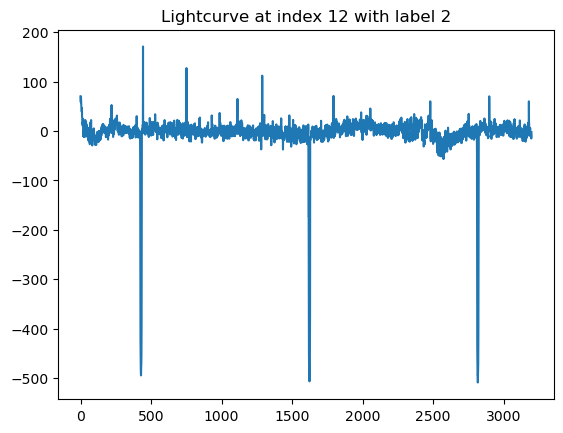

In [5]:
data = df_train_x.to_numpy()
ii = 0
while ii < len(data):
    index = np.random.randint(0, len(data))
    label = df_train_y[index]
    if label == 2.0:
        plt.figure()
        plt.plot(range(len(data[index, :])), data[index, :])
        plt.title(f"Lightcurve at index {index} with label {label}")
        break
    ii += 1

In [30]:
# Process dataset
LFP = LightFluxProcessor(
    fourier=True,
    normalize=True,
    gaussian=True,
    standardize=True)
df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

# Rejoin X and Y
df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

# Load X and Y numpy arrays
X_train, Y_train = np_X_Y_from_df(df_train_processed)
X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!


In [31]:
(num_examples, n_x) = X_train.shape # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[1] # n_y : output size
print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_dev.shape: ", X_dev.shape)
print("Y_dev.shape: ", Y_dev.shape)
print("n_x: ", n_x)
print("num_examples: ", num_examples)
print("n_y: ", n_y)

X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
n_x:  1598
num_examples:  5087
n_y:  1


### Build Model, Train, and Predict
We perform a gridsearch on the value of the regolarization parameter C, the type of kernel and its related parameters.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.1, kernel=linear, max_iter=500;, score=1.000 total time=   0.6s
[CV 2/5] END C=0.1, kernel=linear, max_iter=500;, score=1.000 total time=   0.6s
[CV 3/5] END C=0.1, kernel=linear, max_iter=500;, score=0.857 total time=   0.6s
[CV 5/5] END C=0.1, kernel=linear, max_iter=500;, score=1.000 total time=   0.7s
[CV 2/5] END ..C=1, kernel=linear, max_iter=500;, score=1.000 total time=   0.9s
[CV 4/5] END C=0.1, kernel=linear, max_iter=500;, score=1.000 total time=   1.0s
[CV 1/5] END ..C=1, kernel=linear, max_iter=500;, score=1.000 total time=   1.2s
[CV 5/5] END ..C=1, kernel=linear, max_iter=500;, score=1.000 total time=   1.0s
[CV 3/5] END ..C=1, kernel=linear, max_iter=500;, score=0.857 total time=   1.0s
[CV 4/5] END ..C=1, kernel=linear, max_iter=500;, score=1.000 total time=   1.1s
[CV 2/5] END .C=10, kernel=linear, max_iter=500;, score=1.000 total time=   0.9s
[CV 1/5] END .C=10, kernel=linear, max_iter=500;

,param_kernel,param_C,param_degree,param_gamma,mean_test_score
0,linear,0.1,NaN,NaN,0.971429
1,linear,1.0,NaN,NaN,0.971429
2,linear,10.0,NaN,NaN,0.971429
3,poly,0.1,4.0,NaN,0.971429
4,poly,1.0,4.0,NaN,0.971429
5,poly,10.0,4.0,NaN,0.971429
8,rbf,1.0,NaN,scale,0.971429
9,rbf,1.0,NaN,auto,0.971429
10,rbf,10.0,NaN,scale,0.971429
11,rbf,10.0,NaN,auto,0.971429


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=1.000 total time=   0.3s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=1.000 total time=   0.2s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=1.000 total time=   0.2s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=1.000 total time=   0.3s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=1.000 total time=   0.2s


,param_kernel,param_C,param_degree,param_gamma,mean_test_score,rank_test_score
0,linear,0.1,None,None,1.0,1


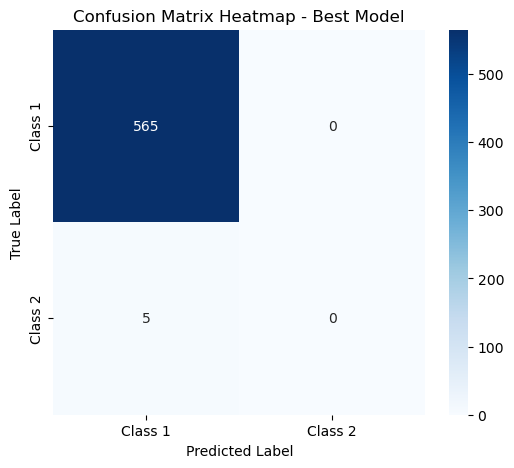

In [12]:
my_grid_search(X_train=X_train, Y_train=Y_train, X_dev=X_dev, Y_dev=Y_dev)

We obtain as best model a linear kernel with regularization parameter C=0.1. Even this best-performing kernel entirely misclassifies the few data points belonging to class 2. This is due to the highly imbalanced dataset, making it particularly difficult to correctly classify objects from the minority class.

We plot below the confusion matrices and the metrics for the three kernels:

Results for Linear SVC
 
Train Set Error 0.0
Dev Set Error 0.0035087719298245723
------------
Precision - Train Set 1.0
Precision - Dev Set 0.7142857142857143
------------
Recall - Train Set 1.0
Recall - Dev Set 1.0
------------
Confusion Matrix - Train Set
[[5050    0]
 [   0   37]]
Confusion Matrix - Dev Set
[[563   2]
 [  0   5]]
------------
 
Results for Polynomial SVC (degree=4)
 
Train Set Error 0.00019657951641438576
Dev Set Error 0.00877192982456143
------------
Precision - Train Set 1.0
Precision - Dev Set 0.0
------------
Recall - Train Set 0.972972972972973
Recall - Dev Set 0.0
------------
Confusion Matrix - Train Set
[[5050    0]
 [   1   36]]
Confusion Matrix - Dev Set
[[565   0]
 [  5   0]]
------------
 
Results for RBF SVC
 
Train Set Error 0.00019657951641438576
Dev Set Error 0.00877192982456143
------------
Precision - Train Set 1.0
Precision - Dev Set 0.0
------------
Recall - Train Set 0.972972972972973
Recall - Dev Set 0.0
------------
Confusion Matrix - Train Se

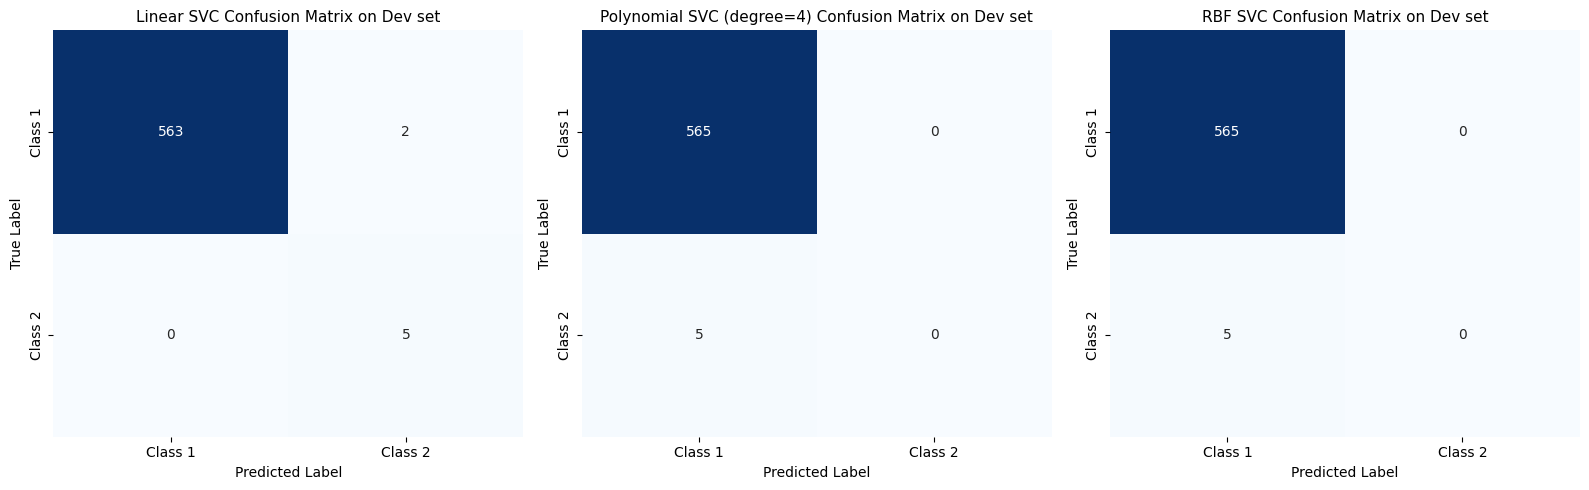

In [35]:
model_linear = LinearSVC(C=0.1)
model_poly4=SVC(kernel='poly',degree=int(4), C=0.1)
model_rbf=SVC(kernel='rbf', C=1)
list_models=[model_linear,model_poly4,model_rbf]
model_names = ['Linear SVC', 'Polynomial SVC (degree=4)', 'RBF SVC']
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, model, name in zip(axes, list_models, model_names):
    model.fit(X_train, Y_train.reshape(-1))
    train_outputs = model.predict(X_train)
    dev_outputs = model.predict(X_dev)

    accuracy_train = accuracy_score(Y_train.reshape(-1), train_outputs)
    accuracy_dev = accuracy_score(Y_dev.reshape(-1), dev_outputs)
    precision_train = precision_score(Y_train.reshape(-1), train_outputs)
    precision_dev = precision_score(Y_dev.reshape(-1), dev_outputs)
    recall_train = recall_score(Y_train.reshape(-1), train_outputs)
    recall_dev = recall_score(Y_dev.reshape(-1), dev_outputs)
    confusion_matrix_train = confusion_matrix(Y_train.reshape(-1), train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev.reshape(-1), dev_outputs)

    print(f"Results for {name}")
    print(" ")
    print("Train Set Error", 1.0 - accuracy_train)
    print("Dev Set Error", 1.0 - accuracy_dev)
    print("------------")
    print("Precision - Train Set", precision_train)
    print("Precision - Dev Set", precision_dev)
    print("------------")
    print("Recall - Train Set", recall_train)
    print("Recall - Dev Set", recall_dev)
    print("------------")
    print("Confusion Matrix - Train Set")
    print(confusion_matrix_train)
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix_dev)
    print("------------")
    print(" ")

    sns.heatmap(confusion_matrix_dev, annot=True, fmt='d', cmap='Blues',cbar=False, xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'],ax=ax)
    ax.set_title(f"{name} Confusion Matrix on Dev set", fontsize=11)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show() 

## Assignment 2E

For this task, we identify planets in the *data_injected* dataset. This dataset includes systems with simulated exoplanets, balanced to achieve a 50-50 distribution between the two classes.

In [36]:
#root_dir = "/ca24/comp_astro_24/data_injected"
root_dir = '/home/gaia/third_semester/COMP-ASTRO/data/machine_learning/kepler/data_injected'
train_dataset_path = os.path.join(root_dir, "./exoTrain.csv")
dev_dataset_path = os.path.join(root_dir, "./exoTest.csv")

# Generate X and Y dataframe sets
df_train_inj = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1", low_memory=False)
df_dev_inj = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1", low_memory=False)
# Generate X and Y dataframe sets
df_train_x_inj = df_train_inj.drop('LABEL', axis=1)
df_dev_x_inj = df_dev_inj.drop('LABEL', axis=1)
df_train_y_inj = df_train_inj.LABEL
df_dev_y_inj = df_dev_inj.LABEL
display(df_train_inj)
data_inj = df_train_x_inj.to_numpy()
# Process dataset
LFP = LightFluxProcessor(
    fourier=True,
    normalize=True,
    gaussian=True,
    standardize=True)
df_train_x_inj, df_dev_x_inj = LFP.process(df_train_x_inj, df_dev_x_inj)

# Rejoin X and Y
df_train_inj_processed = pd.DataFrame(df_train_x_inj).join(pd.DataFrame(df_train_y_inj))
df_dev_inj_processed = pd.DataFrame(df_dev_x_inj).join(pd.DataFrame(df_dev_y_inj))

# Load X and Y numpy arrays
X_train_inj, Y_train_inj = np_X_Y_from_df(df_train_inj_processed)
X_dev_inj, Y_dev_inj = np_X_Y_from_df(df_dev_inj_processed)

#describe datasets 
(num_examples_inj, n_x_inj) = X_train_inj.shape # (n_x: input size, m : number of examples in the train set)
n_y_inj = Y_train_inj.shape[1] # n_y : output size
print("X_train_inj.shape: ", X_train_inj.shape)
print("Y_train_inj.shape: ", Y_train_inj.shape)
print("X_dev_inj.shape: ", X_dev_inj.shape)
print("Y_dev_inj.shape: ", Y_dev_inj.shape)
print("n_x_inj: ", n_x_inj)
print("num_examples_inj: ", num_examples_inj)
print("n_y_inj: ", n_y_inj)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2.0,93.850000,83.810000,20.100000,-26.980000,-39.56000,-124.710000,-135.180000,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2.0,-38.850389,-33.789154,-58.496531,-40.046242,-79.26802,-72.774017,-86.544612,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2.0,532.640000,535.920000,513.730000,496.920000,456.45000,466.000000,464.500000,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2.0,326.520000,347.390000,302.350000,298.130000,317.74000,312.700000,322.330000,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2.0,-1107.210000,-1112.590000,-1118.950000,-1095.100000,-1057.55000,-1034.480000,-998.340000,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1.0,-91.910000,-92.970000,-78.760000,-97.330000,-68.00000,-68.240000,-75.480000,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,2.0,989.750000,891.010000,908.530000,851.830000,755.11000,615.780000,595.770000,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,2.0,273.390000,278.000000,261.730000,236.990000,280.73000,264.900000,252.920000,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1.0,3.820000,2.090000,-3.290000,-2.880000,1.66000,-0.750000,3.850000,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
X_train_inj.shape:  (5087, 1598)
Y_train_inj.shape:  (5087, 1)
X_dev_inj.shape:  (570, 1598)
Y_dev_inj.shape:  (570, 1)
n_x_inj:  1598
num_examples_inj:  5087
n_y_inj:  1


### Build Model, Train, and Predict

We still perform a gridsearch over the type of kernel, its related parameters and the regularization C:

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 2/5] END ..C=1, kernel=linear, max_iter=500;, score=0.635 total time=  16.1s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..C=1, kernel=linear, max_iter=500;, score=0.538 total time=  16.7s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..C=1, kernel=linear, max_iter=500;, score=0.493 total time=  17.6s
[CV 3/5] END C=0.1, kernel=linear, max_iter=500;, score=0.661 total time=  19.8s
[CV 5/5] END C=0.1, kernel=linear, max_iter=500;, score=0.811 total time=  20.1s
[CV 2/5] END C=0.1, kernel=linear, max_iter=500;, score=0.488 total time=  20.3s
[CV 1/5] END C=0.1, kernel=linear, max_iter=500;, score=0.654 total time=  21.4s
[CV 4/5] END C=0.1, kernel=linear, max_iter=500;, score=0.680 total time=  21.5s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 4/5] END ..C=1, kernel=linear, max_iter=500;, score=0.481 total time=  14.8s
[CV 2/5] END .C=10, kernel=linear, max_iter=500;, score=0.455 total time=  12.9s
[CV 3/5] END .C=10, kernel=linear, max_iter=500;, score=0.537 total time=  12.8s
[CV 4/5] END .C=10, kernel=linear, max_iter=500;, score=0.580 total time=  12.7s
[CV 1/5] END .C=10, kernel=linear, max_iter=500;, score=0.506 total time=  15.2s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ..C=1, kernel=linear, max_iter=500;, score=0.446 total time=  18.1s
[CV 5/5] END .C=10, kernel=linear, max_iter=500;, score=0.568 total time=  15.3s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, degree=4, kernel=poly, max_iter=500;, score=0.993 total time=  33.0s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 2/5] END C=0.1, degree=4, kernel=poly, max_iter=500;, score=0.995 total time=  31.4s
[CV 4/5] END C=0.1, degree=4, kernel=poly, max_iter=500;, score=0.995 total time=  29.9s
[CV 5/5] END C=0.1, degree=4, kernel=poly, max_iter=500;, score=0.993 total time=  30.3s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, degree=4, kernel=poly, max_iter=500;, score=0.979 total time=  33.2s
[CV 1/5] END C=1, degree=4, kernel=poly, max_iter=500;, score=0.979 total time=  34.0s
[CV 3/5] END C=1, degree=4, kernel=poly, max_iter=500;, score=0.963 total time=  36.0s
[CV 2/5] END C=1, degree=4, kernel=poly, max_iter=500;, score=0.990 total time=  38.1s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 5/5] END C=1, degree=4, kernel=poly, max_iter=500;, score=0.976 total time=  28.0s
[CV 1/5] END C=10, degree=4, kernel=poly, max_iter=500;, score=0.970 total time=  27.7s
[CV 4/5] END C=1, degree=4, kernel=poly, max_iter=500;, score=0.972 total time=  36.1s
[CV 2/5] END C=10, degree=4, kernel=poly, max_iter=500;, score=0.958 total time=  27.5s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, degree=4, kernel=poly, max_iter=500;, score=0.960 total time=  26.8s
[CV 3/5] END C=10, degree=4, kernel=poly, max_iter=500;, score=0.958 total time=  30.5s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, degree=4, kernel=poly, max_iter=500;, score=0.953 total time=  30.8s
[CV 1/5] END C=0.1, gamma=scale, kernel=rbf, max_iter=500;, score=0.264 total time=  35.5s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 4/5] END C=0.1, gamma=scale, kernel=rbf, max_iter=500;, score=0.727 total time=  28.0s
[CV 3/5] END C=0.1, gamma=scale, kernel=rbf, max_iter=500;, score=0.510 total time=  28.3s
[CV 2/5] END C=0.1, gamma=scale, kernel=rbf, max_iter=500;, score=0.570 total time=  28.6s
[CV 5/5] END C=0.1, gamma=scale, kernel=rbf, max_iter=500;, score=0.421 total time=  28.5s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=0.1, gamma=auto, kernel=rbf, max_iter=500;, score=0.264 total time=  28.3s
[CV 2/5] END C=0.1, gamma=auto, kernel=rbf, max_iter=500;, score=0.699 total time=  27.4s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=0.1, gamma=auto, kernel=rbf, max_iter=500;, score=0.544 total time=  29.7s
[CV 4/5] END C=0.1, gamma=auto, kernel=rbf, max_iter=500;, score=0.360 total time=  30.0s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 1/5] END C=1, gamma=scale, kernel=rbf, max_iter=500;, score=0.702 total time=  29.3s
[CV 5/5] END C=0.1, gamma=auto, kernel=rbf, max_iter=500;, score=0.421 total time=  29.5s
[CV 3/5] END C=1, gamma=scale, kernel=rbf, max_iter=500;, score=0.070 total time=  29.5s
[CV 2/5] END C=1, gamma=scale, kernel=rbf, max_iter=500;, score=0.493 total time=  29.7s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1, gamma=scale, kernel=rbf, max_iter=500;, score=0.456 total time=  29.6s
[CV 5/5] END C=1, gamma=scale, kernel=rbf, max_iter=500;, score=0.507 total time=  30.8s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1, gamma=auto, kernel=rbf, max_iter=500;, score=0.714 total time=  28.0s
[CV 2/5] END C=1, gamma=auto, kernel=rbf, max_iter=500;, score=0.596 total time=  27.4s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

[CV 3/5] END C=1, gamma=auto, kernel=rbf, max_iter=500;, score=0.383 total time=  25.4s
[CV 1/5] END C=10, gamma=scale, kernel=rbf, max_iter=500;, score=0.581 total time=  24.9s
[CV 5/5] END C=1, gamma=auto, kernel=rbf, max_iter=500;, score=0.601 total time=  25.5s
[CV 4/5] END C=1, gamma=auto, kernel=rbf, max_iter=500;, score=0.294 total time=  27.4s
[CV 2/5] END C=10, gamma=scale, kernel=rbf, max_iter=500;, score=0.330 total time=  24.2s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10, gamma=scale, kernel=rbf, max_iter=500;, score=0.316 total time=  26.9s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10, gamma=scale, kernel=rbf, max_iter=500;, score=0.649 total time=  24.9s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10, gamma=scale, kernel=rbf, max_iter=500;, score=0.524 total time=  23.9s


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10, gamma=auto, kernel=rbf, max_iter=500;, score=0.698 total time=  19.2s
[CV 1/5] END C=10, gamma=auto, kernel=rbf, max_iter=500;, score=0.614 total time=  19.4s
[CV 3/5] END C=10, gamma=auto, kernel=rbf, max_iter=500;, score=0.781 total time=  18.9s
[CV 5/5] END C=10, gamma=auto, kernel=rbf, max_iter=500;, score=0.390 total time=  17.4s
[CV 4/5] END C=10, gamma=auto, kernel=rbf, max_iter=500;, score=0.661 total time=  18.0s


,param_kernel,param_C,param_degree,param_gamma,mean_test_score
3,poly,0.1,4.0,NaN,0.990912
4,poly,1.0,4.0,NaN,0.975881
5,poly,10.0,4.0,NaN,0.959801
0,linear,0.1,NaN,NaN,0.658862
11,rbf,10.0,NaN,auto,0.628806
2,linear,10.0,NaN,NaN,0.529194
1,linear,1.0,NaN,NaN,0.518344
9,rbf,1.0,NaN,auto,0.517583
6,rbf,0.1,NaN,scale,0.498509
10,rbf,10.0,NaN,scale,0.480216


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ......C=0.1, degree=4, kernel=poly;, score=0.563 total time=  21.6s
[CV 2/5] END ......C=0.1, degree=4, kernel=poly;, score=0.562 total time=  22.8s
[CV 3/5] END ......C=0.1, degree=4, kernel=poly;, score=0.562 total time=  23.0s
[CV 4/5] END ......C=0.1, degree=4, kernel=poly;, score=0.562 total time=  19.5s
[CV 5/5] END ......C=0.1, degree=4, kernel=poly;, score=0.562 total time=  22.0s


,param_kernel,param_C,param_degree,param_gamma,mean_test_score,rank_test_score
0,poly,0.1,4,None,0.562353,1


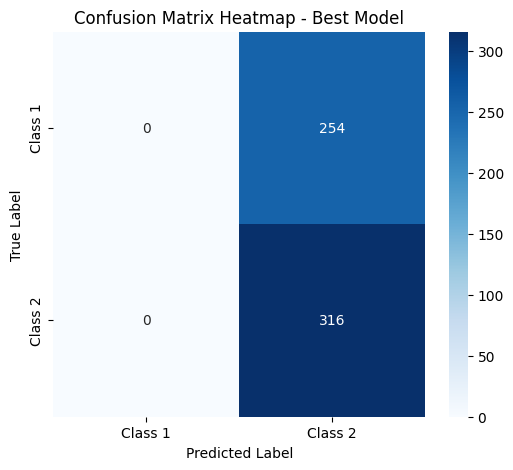

In [16]:
my_grid_search(X_train=X_train_inj, Y_train= Y_train_inj, X_dev=X_dev_inj, Y_dev=Y_dev_inj)

Results for Linear SVC
 
Train Set Error 0.4198938470611362
Dev Set Error 0.43157894736842106
------------
Precision - Train Set 0.5857988165680473
Precision - Dev Set 0.5694444444444444
------------
Recall - Train Set 0.8650821391121986
Recall - Dev Set 0.9082278481012658
------------
Confusion Matrix - Train Set
[[ 476 1750]
 [ 386 2475]]
Confusion Matrix - Dev Set
[[ 37 217]
 [ 29 287]]
------------
 
Results for Polynomial SVC (degree=4)
 
Train Set Error 0.43758600353843125
Dev Set Error 0.44561403508771935
------------
Precision - Train Set 0.5624139964615688
Precision - Dev Set 0.5543859649122806
------------
Recall - Train Set 1.0
Recall - Dev Set 1.0
------------
Confusion Matrix - Train Set
[[   0 2226]
 [   0 2861]]
Confusion Matrix - Dev Set
[[  0 254]
 [  0 316]]
------------
 
Results for RBF SVC
 
Train Set Error 0.38077452329467265
Dev Set Error 0.4614035087719298
------------
Precision - Train Set 0.6159056698444556
Precision - Dev Set 0.547576301615799
------------
Re

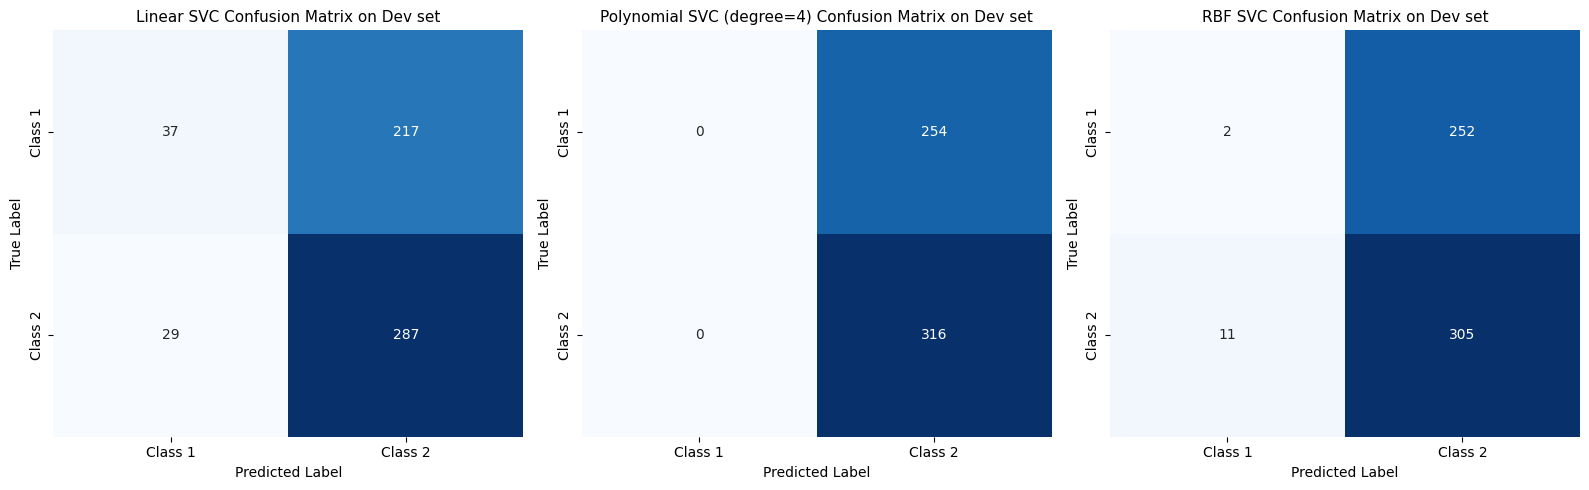

In [37]:
model_linear = LinearSVC(C=0.1)
model_poly4=SVC(kernel='poly',degree=int(4), C=0.1)
model_rbf=SVC(kernel='rbf', C=10)
list_models=[model_linear,model_poly4,model_rbf]
model_names = ['Linear SVC', 'Polynomial SVC (degree=4)', 'RBF SVC']
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, model, name in zip(axes, list_models, model_names):
    model.fit(X_train_inj, Y_train_inj.reshape(-1))
    train_outputs = model.predict(X_train_inj)
    dev_outputs = model.predict(X_dev_inj)

    accuracy_train = accuracy_score(Y_train_inj.reshape(-1), train_outputs)
    accuracy_dev = accuracy_score(Y_dev_inj.reshape(-1), dev_outputs)
    precision_train = precision_score(Y_train_inj.reshape(-1), train_outputs)
    precision_dev = precision_score(Y_dev_inj.reshape(-1), dev_outputs)
    recall_train = recall_score(Y_train_inj.reshape(-1), train_outputs)
    recall_dev = recall_score(Y_dev_inj.reshape(-1), dev_outputs)
    confusion_matrix_train = confusion_matrix(Y_train_inj.reshape(-1), train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev_inj.reshape(-1), dev_outputs)
    classification_report_train = classification_report(Y_train_inj.reshape(-1), train_outputs)
    classification_report_dev = classification_report(Y_dev_inj.reshape(-1), dev_outputs)


    print(f"Results for {name}")
    print(" ")
    print("Train Set Error", 1.0 - accuracy_train)
    print("Dev Set Error", 1.0 - accuracy_dev)
    print("------------")
    print("Precision - Train Set", precision_train)
    print("Precision - Dev Set", precision_dev)
    print("------------")
    print("Recall - Train Set", recall_train)
    print("Recall - Dev Set", recall_dev)
    print("------------")
    print("Confusion Matrix - Train Set")
    print(confusion_matrix_train)
    print("Confusion Matrix - Dev Set")
    print(confusion_matrix_dev)
    print("------------")
    print(" ") 

    sns.heatmap(confusion_matrix_dev, annot=True, fmt='d', cmap='Blues',cbar=False, xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'],ax=ax)
    ax.set_title(f"{name} Confusion Matrix on Dev set", fontsize=11)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

These algorithms do not provide satisfactory results, as they are unable to accurately classify neither of the two classes. This is due to the fact that the signal-to-noise ratio is too low, systems with simulated exoplanets are too close to the background noise. 